Compute statistics for each story

In [340]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import re

In [341]:
# llm-generated stories
llm_stories = ["bookstore", "color", "starlight", "threads", "time", "whispers"]
exclude_stories = ["yourname"]

In [342]:
# load in data files
data_folder = "../src/data/"
data_files = os.listdir(data_folder)
data_files = [f for f in data_files if f.endswith(".json") and 'new' in f]

# remove any stories in "exclude_stories"
data_files = [f for f in data_files if not any([s in f for s in exclude_stories])]

sorted_data_files = sorted(data_files)
sorted_data_files

['alice-new-themes.json',
 'alice-new.json',
 'anne-new-themes.json',
 'anne-new.json',
 'artofwar-new-themes.json',
 'artofwar-new.json',
 'bookstore-new-themes.json',
 'bookstore-new.json',
 'color-new-themes.json',
 'color-new.json',
 'donquixote-new-themes.json',
 'donquixote-new.json',
 'emma-new-themes.json',
 'emma-new.json',
 'faust-new-themes.json',
 'faust-new.json',
 'frankenstein-new-themes.json',
 'frankenstein-new.json',
 'gatsby-new-themes.json',
 'gatsby-new.json',
 'genji-new-themes.json',
 'genji-new.json',
 'greatexp-new-themes.json',
 'greatexp-new.json',
 'hamlet-new-themes.json',
 'hamlet-new.json',
 'iliad-new-themes.json',
 'iliad-new.json',
 'marrow-new-themes.json',
 'marrow-new.json',
 'mendips-new-themes.json',
 'mendips-new.json',
 'metamorphosis-new-themes.json',
 'metamorphosis-new.json',
 'odyssey-new-themes.json',
 'odyssey-new.json',
 'pride-new-themes.json',
 'pride-new.json',
 'redchamber-new-themes.json',
 'redchamber-new.json',
 'romeo-new-themes.j

In [343]:
# create df to store results
# this will have all data points
df = pd.DataFrame(columns=[
    "story", "themes", "llm_generated", 
    "num_lines", "num_chapters", "num_scenes", "num_characters", "num_locations", 
    "real_quote_percent",
    "lines_per_chapter", "scenes_per_chapter", "characters_per_chapter", "locations_per_chapter",
    "lines_per_scene", "characters_per_scene"
    ])

# this is the average of the above
average_df = pd.DataFrame(columns=[
    "story", "themes", "llm_generated", 
    "real_quote_percent",
    "lines_per_chapter", "scenes_per_chapter", "characters_per_chapter", "locations_per_chapter",
    "lines_per_scene", "characters_per_scene"
    ])

In [344]:
all_data = []
average_data = []

# loop through data files
for f in sorted_data_files:
    with open(data_folder + f, 'r') as file:
        data = json.load(file)

    # chapter/scene data
    chapter_data = data["chapters"]
    scene_data = data["scenes"]

    # general info
    story = f.split("-")[0]
    themes = "themes" in f
    llm_generated = story in llm_stories
    num_chapters = data["num_chapters"]
    num_scenes = data["num_scenes"]
    num_characters = data["num_characters"]
    num_locations = data["num_locations"]

    # chapter data
    lines_per_chapter = [chapter["num_lines"] for chapter in chapter_data]
    num_lines = sum(lines_per_chapter)
    scenes_per_chapter = [chapter["scenes"] for chapter in chapter_data]
    characters_per_chapter = [len(chapter["characters"]) for chapter in chapter_data]
    locations_per_chapter = [len(chapter["locations"]) for chapter in chapter_data]

    # scene data
    lines_per_scene = [scene["num_lines"] for scene in scene_data]
    characters_per_scene = [len(scene["characters"]) for scene in scene_data]

    # character data
    # compute number of real and fake quotes
    real_quotes = 0
    fake_quotes = 0
    for scene in scene_data:
        for character in scene["characters"]:
            if "No quote available" in character["quote"]:
                fake_quotes += 1
            else:
                real_quotes += 1

    # compute percentage of real quotes
    total_quotes = real_quotes + fake_quotes
    real_quote_percent = real_quotes / total_quotes

    # Add to the all_data list
    all_data.append({
        "story": story, 
        "themes": themes, 
        "llm_generated": llm_generated,
        "num_lines": num_lines, 
        "num_chapters": num_chapters, 
        "num_scenes": num_scenes, 
        "num_characters": num_characters, 
        "num_locations": num_locations, 
        "real_quote_percent": real_quote_percent,
        "lines_per_chapter": lines_per_chapter,
        "scenes_per_chapter": scenes_per_chapter,
        "characters_per_chapter": characters_per_chapter, 
        "locations_per_chapter": locations_per_chapter, 
        "lines_per_scene": lines_per_scene, 
        "characters_per_scene": characters_per_scene
    })

    # Add to the average_data list
    average_data.append({
        "story": story, 
        "themes": themes, 
        "llm_generated": llm_generated,
        "real_quote_percent": real_quote_percent,
        "lines_per_chapter": sum(lines_per_chapter) / num_chapters,
        "scenes_per_chapter": sum(scenes_per_chapter) / num_chapters,
        "characters_per_chapter": sum(characters_per_chapter) / num_chapters, 
        "locations_per_chapter": sum(locations_per_chapter) / num_chapters, 
        "lines_per_scene": sum(lines_per_scene) / num_scenes, 
        "characters_per_scene": sum(characters_per_scene) / num_scenes,
    })

# Convert lists to DataFrames
df = pd.DataFrame(all_data)
average_df = pd.DataFrame(average_data)

In [345]:
# number of stories
num_stories = len(df["story"].unique())
num_stories

30

In [346]:
# print number of stories that are not LLM-generated
num_non_llm = df[df["llm_generated"] == False]["story"].unique()
num_non_llm

array(['alice', 'anne', 'artofwar', 'donquixote', 'emma', 'faust',
       'frankenstein', 'gatsby', 'genji', 'greatexp', 'hamlet', 'iliad',
       'marrow', 'mendips', 'metamorphosis', 'odyssey', 'pride',
       'redchamber', 'romeo', 'trial', 'ulysses', 'victoria', 'war',
       'wizard'], dtype=object)

In [347]:
df.head()

,story,themes,llm_generated,num_lines,num_chapters,num_scenes,num_characters,num_locations,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene
0,alice,True,False,2463,12,58,61,21,0.922619,"[181, 172, 156, 216, 213, 235, 232, 231, 224, ...","[8, 6, 7, 8, 2, 5, 2, 5, 5, 5, 4, 1]","[13, 12, 16, 14, 3, 10, 7, 8, 13, 10, 7, 3]","[6, 4, 3, 5, 1, 3, 2, 2, 4, 2, 1, 1]","[21, 57, 13, 19, 22, 5, 14, 14, 29, 10, 42, 25...","[3, 4, 3, 3, 2, 2, 2, 2, 3, 3, 3, 4, 3, 2, 3, ..."
1,alice,False,False,2463,12,60,36,22,0.806818,"[181, 172, 156, 216, 213, 235, 232, 231, 224, ...","[6, 2, 6, 7, 2, 5, 2, 4, 7, 5, 6, 8]","[2, 2, 10, 6, 3, 7, 4, 9, 6, 3, 11, 11]","[5, 1, 4, 4, 2, 4, 2, 1, 4, 1, 1, 3]","[21, 57, 32, 16, 22, 14, 29, 75, 16, 30, 32, 1...","[2, 1, 2, 1, 1, 1, 1, 2, 3, 5, 3, 3, 2, 6, 2, ..."
2,anne,True,False,9064,36,229,238,48,0.941828,"[297, 410, 199, 197, 168, 162, 106, 253, 216, ...","[4, 5, 5, 6, 1, 4, 3, 5, 6, 5, 5, 4, 8, 4, 8, ...","[7, 11, 12, 12, 4, 11, 7, 10, 15, 13, 14, 11, ...","[3, 1, 2, 1, 1, 3, 1, 1, 2, 3, 4, 3, 4, 2, 3, ...","[65, 11, 133, 22, 20, 40, 40, 260, 50, 37, 26,...","[3, 2, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 4, 3, ..."
3,anne,False,False,9064,36,214,44,17,0.755776,"[297, 410, 199, 197, 168, 162, 106, 253, 216, ...","[3, 7, 6, 6, 1, 4, 1, 5, 6, 6, 5, 4, 4, 8, 5, ...","[3, 3, 3, 3, 2, 6, 2, 2, 4, 4, 5, 5, 3, 4, 6, ...","[3, 3, 1, 1, 1, 2, 1, 1, 1, 3, 3, 2, 2, 1, 2, ...","[66, 37, 22, 20, 40, 40, 26, 140, 74, 70, 13, ...","[2, 2, 3, 1, 2, 1, 1, 2, 2, 2, 2, 3, 2, 3, 3, ..."
4,artofwar,True,False,7571,13,165,255,16,0.950000,"[148, 149, 211, 145, 222, 250, 2660, 1675, 400...","[15, 12, 13, 7, 17, 8, 12, 1, 12, 15, 31, 3, 19]","[27, 25, 28, 19, 34, 21, 34, 4, 27, 33, 62, 11...","[3, 6, 3, 2, 6, 3, 3, 1, 4, 4, 7, 2, 8]","[4, 4, 5, 11, 6, 2, 9, 4, 3, 30, 7, 10, 6, 27,...","[2, 2, 1, 2, 3, 4, 2, 1, 2, 4, 2, 2, 2, 4, 2, ..."


In [348]:
average_df.head()

,story,themes,llm_generated,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene
0,alice,True,False,0.922619,205.250000,4.833333,9.666667,2.833333,41.137931,2.896552
1,alice,False,False,0.806818,205.250000,5.000000,6.166667,2.666667,38.866667,2.933333
2,anne,True,False,0.941828,251.777778,6.361111,15.444444,3.138889,36.196507,3.152838
3,anne,False,False,0.755776,251.777778,5.944444,6.111111,2.333333,37.766355,2.831776
4,artofwar,True,False,0.950000,582.384615,12.692308,28.153846,4.000000,21.824242,2.787879


In [349]:
# get average for average_df
llm_avg = average_df.groupby(["llm_generated"]).mean(numeric_only=True)
theme_avg = average_df.groupby(["themes"]).mean(numeric_only=True)

# sd for average_df
llm_sd = average_df.groupby(["llm_generated"]).std(numeric_only=True)
theme_sd = average_df.groupby(["themes"]).std(numeric_only=True)

In [350]:
llm_avg

,themes,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene
llm_generated,,,,,,,,
False,0.5,0.851472,523.481528,6.966097,13.155510,4.080975,64.283751,3.115782
True,0.5,0.904138,132.361111,3.923611,6.888889,2.548611,33.120415,2.849313


In [351]:
llm_sd

,themes,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene
llm_generated,,,,,,,,
False,0.505291,0.110341,321.562348,2.749386,6.751188,2.065066,36.733204,0.308791
True,0.522233,0.061593,10.146237,0.752486,3.137291,0.655646,5.025008,0.491980


In [352]:
theme_avg

,llm_generated,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene
themes,,,,,,,,
False,0.2,0.790097,445.257444,6.213837,8.626411,3.725249,58.494885,2.932044
True,0.2,0.933914,445.257444,6.501363,15.177961,3.823756,57.607283,3.192932


In [353]:
theme_sd

,llm_generated,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene
themes,,,,,,,,
False,0.406838,0.101946,330.349978,2.479284,4.373458,1.788277,35.688321,0.44004
True,0.406838,0.031591,330.349978,3.056217,7.019500,2.156117,35.268142,0.20251


In [354]:
def compare_strings(s1: str, s2: str) -> bool:
    """
    Compare if two strings are equal ignoring case and punctuation.

    Args:
        s1 (str): The first string to compare.
        s2 (str): The second string to compare.

    Returns:
        bool: True if the strings are equal ignoring case and punctuation, False otherwise.
    """
    # Remove punctuation and convert to lowercase
    def preprocess(s: str) -> str:
        # Normalize case and remove punctuation except periods for 'CHAPTER X.'
        s = ''.join(char.lower() if char != '.' else '' for char in s if char not in string.punctuation or char == '.')
        # Extract "chapter <number>" using regex
        match = re.match(r'\bchapter\s+\w+', s)
        return match.group(0) if match else s.strip()

    return preprocess(s1) == preprocess(s2)

In [355]:
# read in original story data from data/scenes_per_chapter.csv
original_data = pd.read_csv("data/scenes_per_chapter.csv")

og_stories = original_data["story"].unique()

# remove any stories in "exclude_stories"
og_stories = [s for s in og_stories if s not in exclude_stories]

og_stories

['gatsby',
 'romeo',
 'alice',
 'mendips',
 'victoria',
 'color',
 'whispers',
 'bookstore',
 'starlight',
 'time',
 'threads']

In [356]:
# get diffs between ground truth and generated data
og_diffs = []
for story in og_stories:
    theme_data = df[(df["story"] == story) & (df["themes"] == True)]
    non_theme_data = df[(df["story"] == story) & (df["themes"] == False)]

    story_chapters = original_data[original_data["story"] == story]["chapter"].values

    with open(data_folder + story + "-new.json", 'r') as file:
        char_data = json.load(file)

    with open(data_folder + story + "-new-themes.json", 'r') as file:
        themes_data = json.load(file)

    non_theme_chapters = char_data["chapters"]
    theme_chapters = themes_data["chapters"]

    non_theme_names = [chapter["chapter"] for chapter in non_theme_chapters]
    theme_names = [chapter["chapter"] for chapter in theme_chapters]

    # collect chapters in both versions
    non_theme_matches = []
    theme_matches = []
    for non_theme_chapter in non_theme_names:
        if any(compare_strings(non_theme_chapter, story_chapter) for story_chapter in story_chapters):
            non_theme_matches.append(non_theme_chapter)
    for theme_chapter in theme_names:
        if any(compare_strings(theme_chapter, story_chapter) for story_chapter in story_chapters):
            theme_matches.append(theme_chapter)

    # print(f"Story: {story}")
    # print(f"Non-theme chapters: {non_theme_matches}")
    # print(f"Theme chapters: {theme_matches}")

    scenes_per_chapter_diff_nontheme = []
    scenes_per_chapter_diff_theme = []
    for chapter in non_theme_matches:
        og_chapter_name = next((story_chapter for story_chapter in story_chapters if compare_strings(chapter, story_chapter)), None)
        og_chapter = original_data[(original_data["story"] == story) & (original_data["chapter"] == og_chapter_name)]
        gen_chapter = char_data["chapters"][non_theme_names.index(chapter)]
        scenes_per_chapter_diff_nontheme.append((og_chapter["scenes"].values[0] - gen_chapter["scenes"]))
    for chapter in theme_matches:
        og_chapter_name = next((story_chapter for story_chapter in story_chapters if compare_strings(chapter, story_chapter)), None)
        og_chapter = original_data[(original_data["story"] == story) & (original_data["chapter"] == og_chapter_name)]
        gen_chapter = themes_data["chapters"][theme_names.index(chapter)]
        scenes_per_chapter_diff_theme.append((og_chapter["scenes"].values[0] - gen_chapter["scenes"]))
    
    avg_scene_per_chapter_diff_nontheme = np.mean(scenes_per_chapter_diff_nontheme)
    avg_scene_per_chapter_diff_theme = np.mean(scenes_per_chapter_diff_theme)

    # append one entry for non-theme and one for theme
    og_diffs.append({
        "story": story,
        "themes": False,
        "llm_generated": non_theme_data["llm_generated"].values[0],
        "scene_per_chapter_diff": scenes_per_chapter_diff_nontheme,
        "avg_scene_per_chapter_diff": avg_scene_per_chapter_diff_nontheme
    })

    og_diffs.append({
        "story": story,
        "themes": True,
        "llm_generated": theme_data["llm_generated"].values[0],
        "scene_per_chapter_diff": scenes_per_chapter_diff_theme,
        "avg_scene_per_chapter_diff": avg_scene_per_chapter_diff_theme
    })

# convert to DataFrame
print(len(og_diffs))
og_diffs_df = pd.DataFrame(og_diffs)
og_diffs_df.head()

22


,story,themes,llm_generated,scene_per_chapter_diff,avg_scene_per_chapter_diff
0,gatsby,False,False,"[-1, -3, -9, -1, -8, -2, -3, 1, 0]",-2.888889
1,gatsby,True,False,"[-7, -4, 1, 0, -7, -2, -3, 2, 2]",-2.000000
2,romeo,False,False,"[2, 0, 0, 0, -2]",0.000000
3,romeo,True,False,"[2, 0, 0, 0, -2]",0.000000
4,alice,False,False,"[-4, -1, -5, -6, 0, -4, -1, -3, -6, -4, -5, -6]",-3.750000


In [357]:
og_diff_avg_themes = og_diffs_df.groupby(["themes"]).mean(numeric_only=True)
og_diff_sd_themes = og_diffs_df.groupby(["themes"]).std(numeric_only=True)

og_diff_avg_themes, og_diff_sd_themes

(        llm_generated  avg_scene_per_chapter_diff
 themes                                           
 False        0.545455                   -1.640969
 True         0.545455                   -1.544563,
         llm_generated  avg_scene_per_chapter_diff
 themes                                           
 False        0.522233                    2.444575
 True         0.522233                    2.360060)

In [358]:
og_diff_avg_llm = og_diffs_df.groupby(["llm_generated"]).mean(numeric_only=True)
og_diff_sd_llm = og_diffs_df.groupby(["llm_generated"]).std(numeric_only=True)

og_diff_avg_llm, og_diff_sd_llm

(               themes  avg_scene_per_chapter_diff
 llm_generated                                    
 False             0.5                   -3.495752
 True              0.5                   -0.006944,
                  themes  avg_scene_per_chapter_diff
 llm_generated                                      
 False          0.527046                    2.292982
 True           0.522233                    0.404299)

In [359]:
# get diffs between theme and non-theme version of each story
diffs = []
for story in df["story"].unique():
    # print(story)
    theme_data = df[(df["story"] == story) & (df["themes"] == True)]
    non_theme_data = df[(df["story"] == story) & (df["themes"] == False)]

    # diff in number of chapters, scenes and locations per story
    diff_num_chapters = non_theme_data["num_chapters"].values[0] - theme_data["num_chapters"].values[0]
    diff_num_scenes = non_theme_data["num_scenes"].values[0] - theme_data["num_scenes"].values[0]
    diff_num_locations = non_theme_data["num_locations"].values[0] - theme_data["num_locations"].values[0]

    with open(data_folder + story + "-new.json", 'r') as file:
        char_data = json.load(file)

    with open(data_folder + story + "-new-themes.json", 'r') as file:
        themes_data = json.load(file)

    non_theme_chapters = char_data["chapters"]
    theme_chapters = themes_data["chapters"]

    non_theme_names = [chapter["chapter"] for chapter in non_theme_chapters]
    theme_names = [chapter["chapter"] for chapter in theme_chapters]

    # collect chapters in both versions
    common_chapters = []
    for non_theme_chapter in non_theme_names:
        if any(compare_strings(non_theme_chapter, theme_chapter) for theme_chapter in theme_names):
            common_chapters.append(non_theme_chapter)

    # diff in number of scenes and locations per chapter
    scenes_per_chapter_diff = []
    locations_per_chapter_diff = []
    for chapter in common_chapters:
        non_theme_chapter = next((c for c in non_theme_chapters if compare_strings(c["chapter"], chapter)), None)
        theme_chapter = next((c for c in theme_chapters if compare_strings(c["chapter"], chapter)), None)
        scenes_per_chapter_diff.append(non_theme_chapter["scenes"] - theme_chapter["scenes"])
        locations_per_chapter_diff.append(len(non_theme_chapter["locations"]) - len(theme_chapter["locations"]))
    avg_scene_per_chapter_diff = np.mean(scenes_per_chapter_diff)
    avg_location_per_chapter_diff = np.mean(locations_per_chapter_diff)

    # diff in number of real/fake quotes
    real_quotes_diff = non_theme_data["real_quote_percent"].values[0] - theme_data["real_quote_percent"].values[0]

    # diff in number of lines per scene
    theme_data_avg = average_df[(average_df["story"] == story) & (average_df["themes"] == True)]
    non_theme_data_avg = average_df[(average_df["story"] == story) & (average_df["themes"] == False)]
    scene_lines_diff = non_theme_data_avg["lines_per_scene"].values[0] - theme_data_avg["lines_per_scene"].values[0]


    # append to diffs
    diffs.append({
        "story": story,
        "llm_generated": theme_data["llm_generated"].values[0],
        "diff_num_chapters": diff_num_chapters,
        "diff_num_scenes": diff_num_scenes,
        "diff_num_locations": diff_num_locations,
        "scene_per_chapter_diff": scenes_per_chapter_diff,
        "avg_scene_per_chapter_diff": avg_scene_per_chapter_diff,
        "locations_per_chapter_diff": locations_per_chapter_diff,
        "avg_location_per_chapter_diff": avg_location_per_chapter_diff,
        "real_quote_percent_diff": real_quotes_diff,
        "scene_lines_diff": scene_lines_diff
    })

# convert to DataFrame
diff_df = pd.DataFrame(diffs)
diff_df.head()

,story,llm_generated,diff_num_chapters,diff_num_scenes,diff_num_locations,scene_per_chapter_diff,avg_scene_per_chapter_diff,locations_per_chapter_diff,avg_location_per_chapter_diff,real_quote_percent_diff,scene_lines_diff
0,alice,False,0,2,1,"[-2, -4, -1, -1, 0, 0, 0, -1, 2, 0, 2, 7]",0.166667,"[-1, -3, 1, -1, 1, 1, 0, -1, 0, -1, 0, 2]",-0.166667,-0.115801,-2.271264
1,anne,False,0,-15,-31,"[-1, 2, 1, 0, 0, 0, -2, 0, 0, 1, 0, 0, -4, 4, ...",-0.416667,"[0, 2, -1, 0, 0, -1, 0, 0, -1, 0, -1, -1, -2, ...",-0.805556,-0.186053,1.569849
2,artofwar,False,0,-29,-5,"[-9, -4, -6, -5, -6, -2, -4, 9, 0, 1, -3, 0, 0]",-2.230769,"[0, -1, -1, -1, -3, 0, -1, 4, 1, 1, 0, 0, -2]",-0.230769,-0.092450,5.021346
3,bookstore,True,0,1,1,"[0, 0, -1, 1, 0, 0, 0, 0, 0, 1, 0, 0]",0.083333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,-0.042400,-1.257317
4,color,True,0,-3,-2,"[-1, -2, 0, 0, -1, 0, 2, 0, 0, 0, -1, 0]",-0.250000,"[1, 0, 0, 0, -1, 1, 0, 0, 0, 0, -1, 0]",0.000000,-0.041502,3.754167


In [360]:
# get average for diff_df based on llm_generated
llm_diff_avg = diff_df.groupby(["llm_generated"]).mean(numeric_only=True)
llm_diff_avg

,diff_num_chapters,diff_num_scenes,diff_num_locations,avg_scene_per_chapter_diff,avg_location_per_chapter_diff,real_quote_percent_diff,scene_lines_diff
llm_generated,,,,,,,
False,0.0,-6.250000,-9.250000,-0.355936,-0.168273,-0.161853,1.009581
True,0.0,-0.166667,2.833333,-0.013889,0.180556,-0.071673,0.399682


In [361]:
# normalize the data
min_diff_num_scenes = diff_df["diff_num_scenes"].min()
max_diff_num_scenes = diff_df["diff_num_scenes"].max()
# make min and max the same number but opposite sign
new_max_diff_num_scenes = max(abs(min_diff_num_scenes), abs(max_diff_num_scenes))
new_min_diff_num_scenes = -new_max_diff_num_scenes
llm_diff_avg["diff_num_scenes"] = -1 + 2 * ((llm_diff_avg["diff_num_scenes"] - new_min_diff_num_scenes) / (new_max_diff_num_scenes - new_min_diff_num_scenes))
print(new_min_diff_num_scenes, new_max_diff_num_scenes)

min_diff_num_locations = diff_df["diff_num_locations"].min()
max_diff_num_locations = diff_df["diff_num_locations"].max()
new_max_diff_num_locations = max(abs(min_diff_num_locations), abs(max_diff_num_locations))
new_min_diff_num_locations = -new_max_diff_num_locations
llm_diff_avg["diff_num_locations"] = -1 + 2 * ((llm_diff_avg["diff_num_locations"] - new_min_diff_num_locations) / (new_max_diff_num_locations - new_min_diff_num_locations))
print(new_min_diff_num_locations, new_max_diff_num_locations)

min_avg_scene_per_chapter_diff = diff_df["avg_scene_per_chapter_diff"].min()
max_avg_scene_per_chapter_diff = diff_df["avg_scene_per_chapter_diff"].max()
new_max_avg_scene_per_chapter_diff = max(abs(min_avg_scene_per_chapter_diff), abs(max_avg_scene_per_chapter_diff))
new_min_avg_scene_per_chapter_diff = -new_max_avg_scene_per_chapter_diff
llm_diff_avg["avg_scene_per_chapter_diff"] = -1 + 2 * ((llm_diff_avg["avg_scene_per_chapter_diff"] - new_min_avg_scene_per_chapter_diff) / (new_max_avg_scene_per_chapter_diff - new_min_avg_scene_per_chapter_diff))
print(new_min_avg_scene_per_chapter_diff, new_max_avg_scene_per_chapter_diff)

min_avg_location_per_chapter_diff = diff_df["avg_location_per_chapter_diff"].min()
max_avg_location_per_chapter_diff = diff_df["avg_location_per_chapter_diff"].max()
new_max_avg_location_per_chapter_diff = max(abs(min_avg_location_per_chapter_diff), abs(max_avg_location_per_chapter_diff))
new_min_avg_location_per_chapter_diff = -new_max_avg_location_per_chapter_diff
llm_diff_avg["avg_location_per_chapter_diff"] = -1 + 2 * ((llm_diff_avg["avg_location_per_chapter_diff"] - new_min_avg_location_per_chapter_diff) / (new_max_avg_location_per_chapter_diff - new_min_avg_location_per_chapter_diff))
print(new_min_avg_location_per_chapter_diff, new_max_avg_location_per_chapter_diff)

min_scene_lines_diff = diff_df["scene_lines_diff"].min()
max_scene_lines_diff = diff_df["scene_lines_diff"].max()
new_max_scene_lines_diff = max(abs(min_scene_lines_diff), abs(max_scene_lines_diff))
new_min_scene_lines_diff = -new_max_scene_lines_diff
llm_diff_avg["scene_lines_diff"] = -1 + 2 * ((llm_diff_avg["scene_lines_diff"] - new_min_scene_lines_diff) / (new_max_scene_lines_diff - new_min_scene_lines_diff))
print(new_min_scene_lines_diff, new_max_scene_lines_diff)

llm_diff_avg

-67 67
-50 50
-3.7222222222222223 3.7222222222222223
-3.2222222222222223 3.2222222222222223
-21.053037240537236 21.053037240537236


,diff_num_chapters,diff_num_scenes,diff_num_locations,avg_scene_per_chapter_diff,avg_location_per_chapter_diff,real_quote_percent_diff,scene_lines_diff
llm_generated,,,,,,,
False,0.0,-0.093284,-0.185000,-0.095625,-0.052223,-0.161853,0.047954
True,0.0,-0.002488,0.056667,-0.003731,0.056034,-0.071673,0.018985


In [362]:
# sd for diff_df based on llm_generated
llm_diff_sd = diff_df.groupby(["llm_generated"]).std(numeric_only=True)
llm_diff_sd

,diff_num_chapters,diff_num_scenes,diff_num_locations,avg_scene_per_chapter_diff,avg_location_per_chapter_diff,real_quote_percent_diff,scene_lines_diff
llm_generated,,,,,,,
False,0.0,17.258268,21.488622,1.009736,1.077649,0.080618,5.815359
True,0.0,2.136976,3.430258,0.178081,0.178081,0.042928,1.870918


In [363]:
# normalize the data
min_diff_num_chapters = diff_df["diff_num_chapters"].min()
max_diff_num_chapters = diff_df["diff_num_chapters"].max()
new_max_diff_num_chapters = max(abs(min_diff_num_chapters), abs(max_diff_num_chapters))
new_min_diff_num_chapters = -new_max_diff_num_chapters
llm_diff_sd['diff_num_chapters'] = -1 + 2 * ((llm_diff_sd['diff_num_chapters'] - new_min_diff_num_chapters) / (new_max_diff_num_chapters - new_min_diff_num_chapters))
print(new_min_diff_num_chapters, new_max_diff_num_chapters)

llm_diff_sd['diff_num_scenes'] = -1 + 2 * ((llm_diff_sd['diff_num_scenes'] - new_min_diff_num_scenes) / (new_max_diff_num_scenes - new_min_diff_num_scenes))
print(new_min_diff_num_scenes, new_max_diff_num_scenes)

llm_diff_sd['diff_num_locations'] = -1 + 2 * ((llm_diff_sd['diff_num_locations'] - new_min_diff_num_locations) / (new_max_diff_num_locations - new_min_diff_num_locations))
print(new_min_diff_num_locations, new_max_diff_num_locations)

llm_diff_sd['avg_scene_per_chapter_diff'] = -1 + 2 * ((llm_diff_sd['avg_scene_per_chapter_diff'] - new_min_avg_scene_per_chapter_diff) / (new_max_avg_scene_per_chapter_diff - new_min_avg_scene_per_chapter_diff))
print(new_min_avg_scene_per_chapter_diff, new_max_avg_scene_per_chapter_diff)

llm_diff_sd['avg_location_per_chapter_diff'] = -1 + 2 * ((llm_diff_sd['avg_location_per_chapter_diff'] - new_min_avg_location_per_chapter_diff) / (new_max_avg_location_per_chapter_diff - new_min_avg_location_per_chapter_diff))
print(new_min_avg_location_per_chapter_diff, new_max_avg_location_per_chapter_diff)

llm_diff_sd['scene_lines_diff'] = -1 + 2 * ((llm_diff_sd['scene_lines_diff'] - new_min_scene_lines_diff) / (new_max_scene_lines_diff - new_min_scene_lines_diff))
print(new_min_scene_lines_diff, new_max_scene_lines_diff)

llm_diff_sd

0 0
-67 67
-50 50
-3.7222222222222223 3.7222222222222223
-3.2222222222222223 3.2222222222222223
-21.053037240537236 21.053037240537236


,diff_num_chapters,diff_num_scenes,diff_num_locations,avg_scene_per_chapter_diff,avg_location_per_chapter_diff,real_quote_percent_diff,scene_lines_diff
llm_generated,,,,,,,
False,NaN,0.257586,0.429772,0.271272,0.334443,0.080618,0.276224
True,NaN,0.031895,0.068605,0.047843,0.055267,0.042928,0.088867


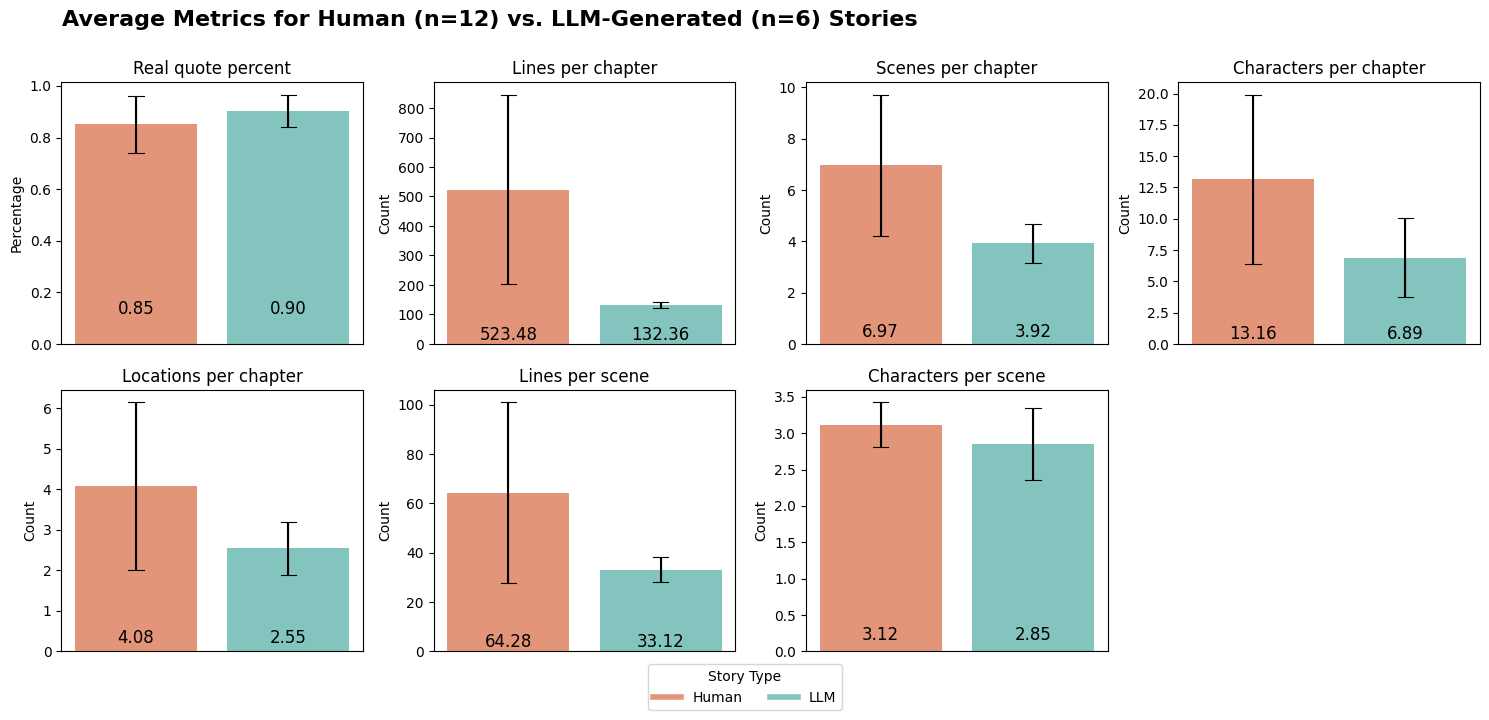

In [364]:
# Plot with adjusted label size and position slightly above y=0
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7), sharex=False, sharey=False)
axes = axes.flatten()

colors = ['#e29578', '#83c5be']

# Transpose for easier plotting
# remove 'theme' row
avg_transposed = llm_avg.transpose()
avg_transposed = avg_transposed.drop('themes')
std_transposed = llm_sd.transpose()
std_transposed = std_transposed.drop('themes')

for i, (metric, values) in enumerate(avg_transposed.iterrows()):
    ax = axes[i]
    std_values = std_transposed.loc[metric]
    
    # Plot bars with error bars
    bars = ax.bar(values.index, values.values, color=colors, yerr=std_values.values, capsize=0)
    
    # Adjusted error bar styling: thinner and gray
    for bar, std in zip(bars, std_values.values):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        # Thinner horizontal lines for error bars
        ax.plot([x - 0.05, x + 0.05], [y + std, y + std], color='black', lw=0.8)  # Top horizontal line
        ax.plot([x - 0.05, x + 0.05], [y - std, y - std], color='black', lw=0.8)  # Bottom horizontal line
        # Thinner vertical line for error bars
        ax.vlines(x, y - std, y + std, color='black', lw=0.8)  # Vertical error line (ensure gray is set explicitly)

    # Add y=0 line (dashed gray)
    ax.axhline(0, color='gray', lw=0.5, ls='--')

    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Count" if metric != "real_quote_percent" else "Percentage")
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_xlabel("")  # Remove x-axis title
    
    # Add labels slightly above y=0
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            0.1,  # Slightly above y=0
            f'{bar.get_height():.2f}',
            ha='center',
            va='bottom',
            fontsize=12  # Slightly larger font size
        )

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)


# add main title
fig.suptitle("Average Metrics for Human (n=12) vs. LLM-Generated (n=6) Stories", fontsize=16, fontweight='bold', x=0.33, y=0.95)

# Add one overall legend with correct color order
fig.legend(labels=['Human', 'LLM'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.06), title="Story Type", handles=[
    plt.Line2D([0], [0], color=colors[0], lw=4),
    plt.Line2D([0], [0], color=colors[1], lw=4),
])
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

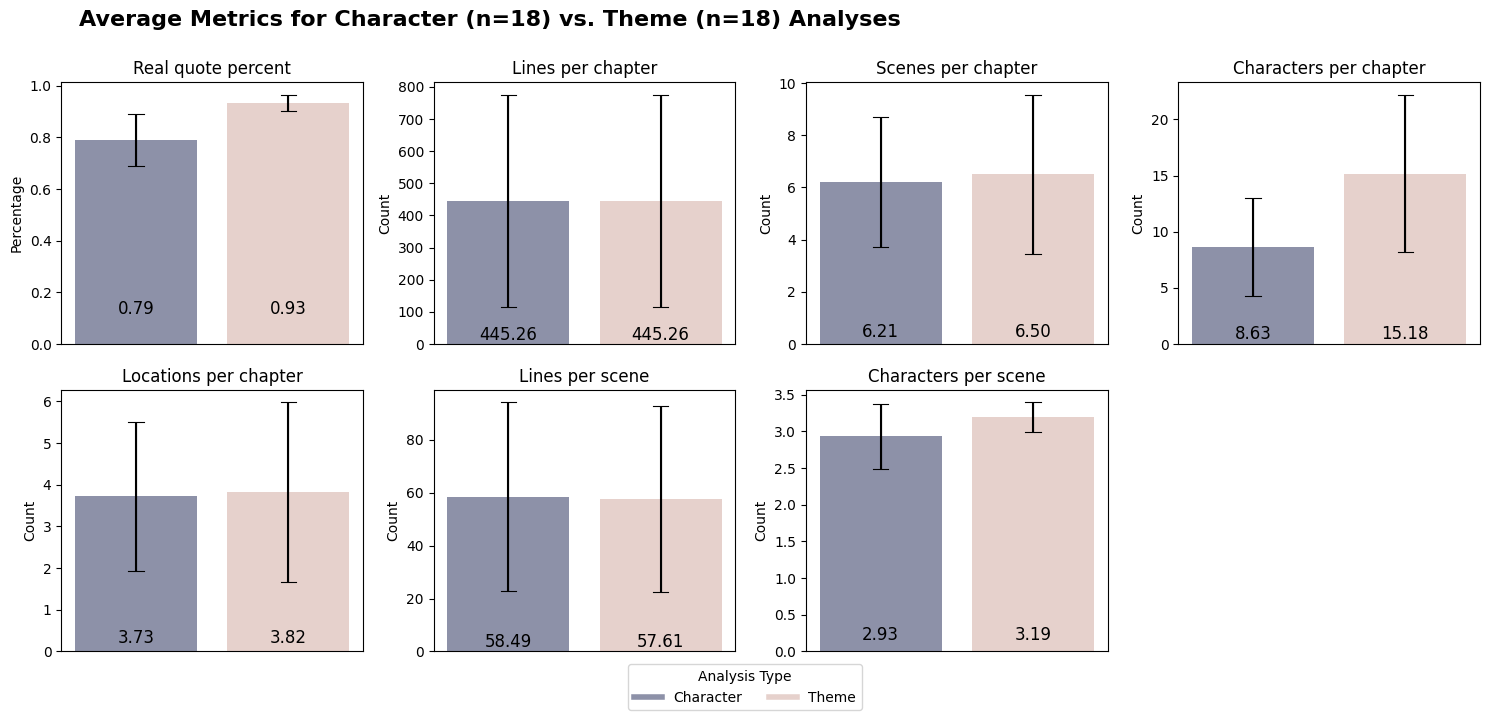

In [365]:
# Plot with adjusted label size and position slightly above y=0
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7), sharex=False, sharey=False)
axes = axes.flatten()

colors = ['#8d91a8', '#e6d1cc']

# Transpose for easier plotting
# remove 'theme' row
avg_transposed = theme_avg.transpose()
avg_transposed = avg_transposed.drop('llm_generated')
std_transposed = theme_sd.transpose()
std_transposed = std_transposed.drop('llm_generated')

for i, (metric, values) in enumerate(avg_transposed.iterrows()):
    ax = axes[i]
    std_values = std_transposed.loc[metric]
    
    # Plot bars with error bars
    bars = ax.bar(values.index, values.values, color=colors, yerr=std_values.values, capsize=0)
    
    # Adjusted error bar styling: thinner and gray
    for bar, std in zip(bars, std_values.values):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        # Thinner horizontal lines for error bars
        ax.plot([x - 0.05, x + 0.05], [y + std, y + std], color='black', lw=0.8)  # Top horizontal line
        ax.plot([x - 0.05, x + 0.05], [y - std, y - std], color='black', lw=0.8)  # Bottom horizontal line
        # Thinner vertical line for error bars
        ax.vlines(x, y - std, y + std, color='black', lw=0.8)  # Vertical error line (ensure gray is set explicitly)

    # Add y=0 line (dashed gray)
    ax.axhline(0, color='gray', lw=0.5, ls='--')

    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Count" if metric != "real_quote_percent" else "Percentage")
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_xlabel("")  # Remove x-axis title
    
    # Add labels slightly above y=0
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            0.1,  # Slightly above y=0
            f'{bar.get_height():.2f}',
            ha='center',
            va='bottom',
            fontsize=12  # Slightly larger font size
        )

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)


# add main title
fig.suptitle("Average Metrics for Character (n=18) vs. Theme (n=18) Analyses", fontsize=16, fontweight='bold', x=0.33, y=0.95)

# Add one overall legend with correct color order
fig.legend(labels=['Character', 'Theme'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.06), title="Analysis Type", handles=[
    plt.Line2D([0], [0], color=colors[0], lw=4),
    plt.Line2D([0], [0], color=colors[1], lw=4),
])
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [366]:
df_lines_exploded = df.explode("lines_per_chapter", ignore_index=True)
df_lines_per_chapter = df_lines_exploded[["story", "llm_generated", "themes", "lines_per_chapter"]]
print(len(df_lines_per_chapter))

df_lines_scene_exploded = df.explode("lines_per_scene", ignore_index=True)
df_lines_per_scene = df_lines_scene_exploded[["story", "llm_generated", "themes", "lines_per_scene"]]
print(len(df_lines_per_scene))

df_characters_exploded = df.explode("characters_per_chapter", ignore_index=True)
df_characters_per_chapter = df_characters_exploded[["story", "llm_generated", "themes", "characters_per_chapter"]]
print(len(df_characters_per_chapter))

df_characters_scene_exploded = df.explode("characters_per_scene", ignore_index=True)
df_characters_per_scene = df_characters_scene_exploded[["story", "llm_generated", "themes", "characters_per_scene"]]
print(len(df_characters_per_scene))

df_locations_exploded = df.explode("locations_per_chapter", ignore_index=True)
df_locations_per_chapter = df_locations_exploded[["story", "llm_generated", "themes", "locations_per_chapter"]]
print(len(df_locations_per_chapter))

df_scenes_exploded = df.explode("scenes_per_chapter", ignore_index=True)
df_scenes_per_chapter = df_scenes_exploded[["story", "llm_generated", "themes", "scenes_per_chapter"]]
print(len(df_scenes_per_chapter))

df_real_quotes_exploded = df.explode("real_quote_percent", ignore_index=True)
df_real_quotes = df_real_quotes_exploded[["story", "llm_generated", "themes", "real_quote_percent"]]
print(len(df_real_quotes))

df_scenes_diff_exploded = diff_df.explode("scene_per_chapter_diff", ignore_index=True)
df_scenes_per_chapter_diff = df_scenes_diff_exploded[["story", "llm_generated", "scene_per_chapter_diff"]]
print(len(df_scenes_per_chapter_diff))

df_locations_diff_exploded = diff_df.explode("locations_per_chapter_diff", ignore_index=True)
df_locations_per_chapter_diff = df_locations_diff_exploded[["story", "llm_generated", "locations_per_chapter_diff"]]
print(len(df_locations_per_chapter_diff))

df_scene_lines_diff_exploded = diff_df.explode("scene_lines_diff", ignore_index=True)
df_scene_lines_diff = df_scene_lines_diff_exploded[["story", "llm_generated", "scene_lines_diff"]]
print(len(df_scene_lines_diff))

df_num_scenes_diff_exploded = diff_df.explode("diff_num_scenes", ignore_index=True)
df_num_scenes_diff = df_num_scenes_diff_exploded[["story", "llm_generated", "diff_num_scenes"]]
print(len(df_num_scenes_diff))

df_num_locations_diff_exploded = diff_df.explode("diff_num_locations", ignore_index=True)
df_num_locations_diff = df_num_locations_diff_exploded[["story", "llm_generated", "diff_num_locations"]]
print(len(df_num_locations_diff))

df_og_scenes_diff_exploded = og_diffs_df.explode("scene_per_chapter_diff", ignore_index=True)
df_og_scenes_per_chapter_diff = df_og_scenes_diff_exploded[["story", "llm_generated", "themes", "scene_per_chapter_diff"]]
print(len(df_og_scenes_per_chapter_diff))

# create map with all df
df_map = {
    "lines_per_chapter": df_lines_per_chapter,
    "lines_per_scene": df_lines_per_scene,
    "characters_per_chapter": df_characters_per_chapter,
    "characters_per_scene": df_characters_per_scene,
    "locations_per_chapter": df_locations_per_chapter,
    "scenes_per_chapter": df_scenes_per_chapter,
    "real_quote_percent": df_real_quotes,
    "scene_per_chapter_diff": df_scenes_per_chapter_diff,
    "locations_per_chapter_diff": df_locations_per_chapter_diff,
    "scene_lines_diff": df_scene_lines_diff,
    "diff_num_scenes": df_num_scenes_diff,
    "diff_num_locations": df_num_locations_diff,
    "og_scene_per_chapter_diff": df_og_scenes_per_chapter_diff
}

1188
7353
1188
7353
1188
1188
60
594
594
30
30
30
250


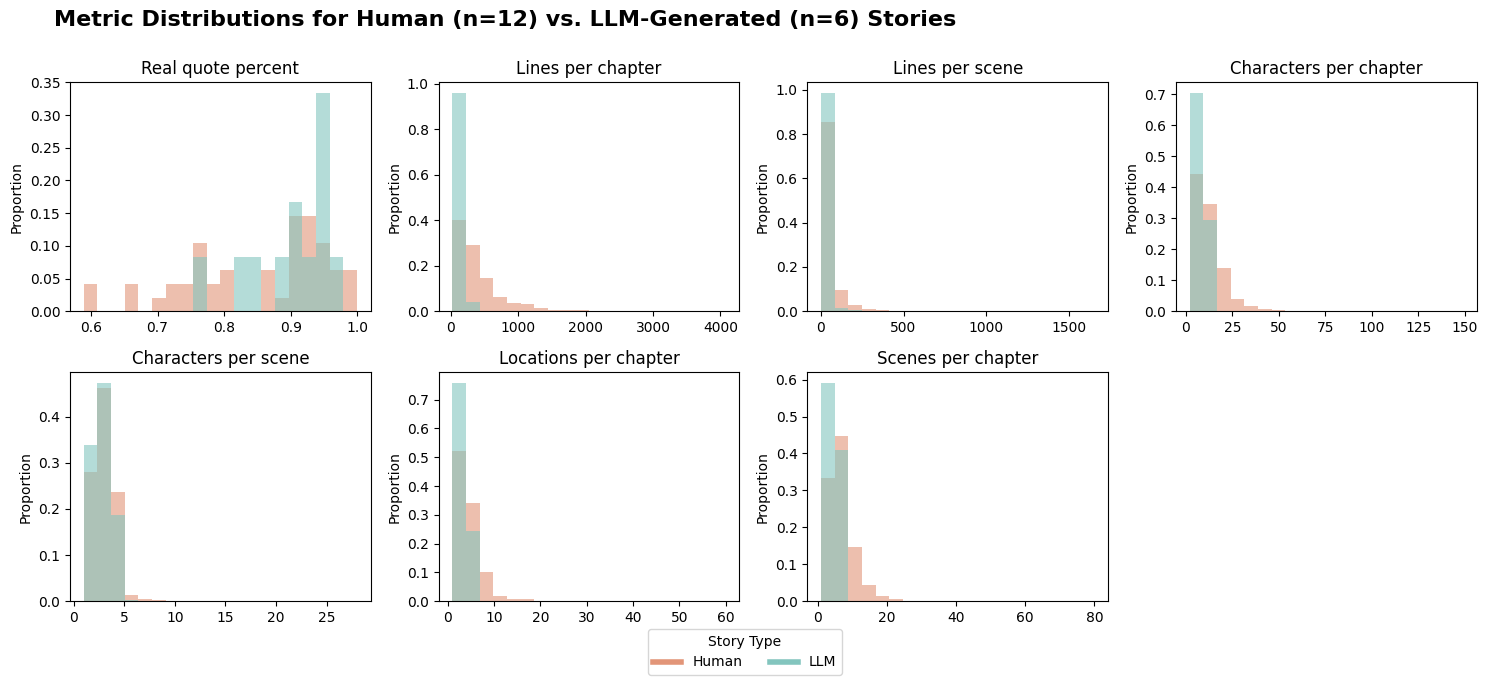

In [367]:
# Define metrics and prepare data
metrics = ['real_quote_percent', 'lines_per_chapter', 'lines_per_scene', 'characters_per_chapter', 'characters_per_scene', 'locations_per_chapter', 'scenes_per_chapter']
num_metrics = len(metrics)
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7), sharex=False, sharey=False)
axes = axes.flatten()

# Colors for the histograms
human_color = '#e29578'
llm_color = '#83c5be'

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for human and LLM-generated separately
    human_data = df_map[metric][df_map[metric]['llm_generated'] == False]
    llm_data = df_map[metric][df_map[metric]['llm_generated'] == True]

    # Normalize Human data
    human_counts, human_bins = np.histogram(human_data[metric], bins=20)
    human_proportions = human_counts / human_counts.sum()  # Normalize to proportions

    # Normalize LLM data
    llm_counts, llm_bins = np.histogram(llm_data[metric], bins=human_bins)  # Use same bins for comparison
    llm_proportions = llm_counts / llm_counts.sum()  # Normalize to proportions

    # Plot histograms for Human data
    ax.bar(human_bins[:-1], human_proportions, width=np.diff(human_bins), color=human_color, alpha=0.6, label="Human", align='edge')

    # Plot histograms for LLM data
    ax.bar(llm_bins[:-1], llm_proportions, width=np.diff(llm_bins), color=llm_color, alpha=0.6, label="LLM", align='edge')

    # Set titles and labels
    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")

# Hide any unused subplots
for j in range(num_metrics, len(axes)):
    axes[j].set_visible(False)

# Add main title
fig.suptitle("Metric Distributions for Human (n=12) vs. LLM-Generated (n=6) Stories", fontsize=16, fontweight='bold', y=0.95, x=0.34)

# Add a single legend
fig.legend(labels=['Human', 'LLM'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.01), title="Story Type",
           handles=[
               plt.Line2D([0], [0], color=human_color, lw=4),
               plt.Line2D([0], [0], color=llm_color, lw=4),
           ])
fig.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()


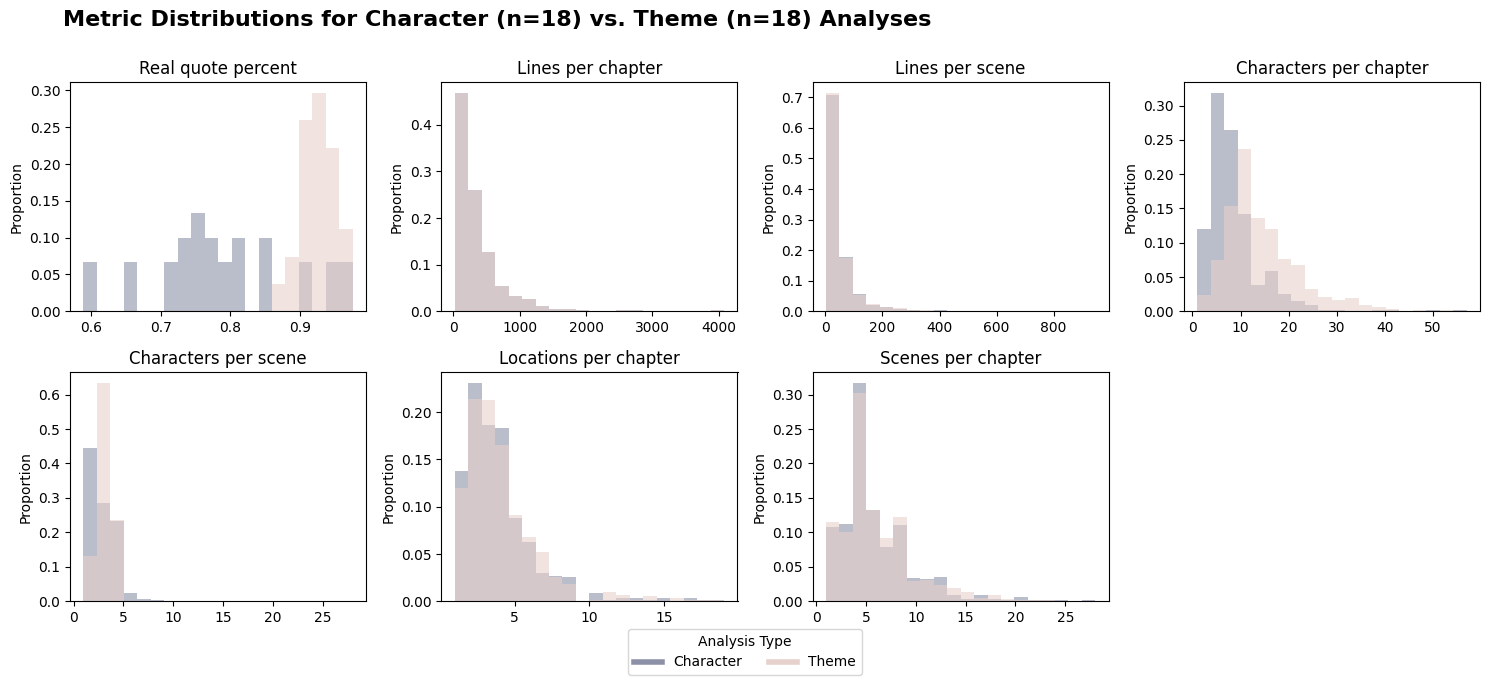

In [368]:
# Define metrics and prepare data
metrics = ['real_quote_percent', 'lines_per_chapter', 'lines_per_scene', 'characters_per_chapter', 'characters_per_scene', 'locations_per_chapter', 'scenes_per_chapter']
num_metrics = len(metrics)
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7), sharex=False, sharey=False)
axes = axes.flatten()

colors = ['#8d91a8', '#e6d1cc']

# Colors for the histograms
character_color = colors[0]
theme_color = colors[1]

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for character and theme analyses separately
    character_data = df_map[metric][df_map[metric]['themes'] == False]
    theme_data = df_map[metric][df_map[metric]['themes'] == True]

    # Normalize Character data
    character_counts, character_bins = np.histogram(character_data[metric], bins=20)
    character_proportions = character_counts / character_counts.sum()  # Normalize to proportions

    # Normalize Theme data
    theme_counts, theme_bins = np.histogram(theme_data[metric], bins=character_bins)  # Use same bins for comparison
    theme_proportions = theme_counts / theme_counts.sum()  # Normalize to proportions

    # Plot histograms for Human data
    ax.bar(character_bins[:-1], character_proportions, width=np.diff(character_bins), color=character_color, alpha=0.6, label="Human", align='edge')

    # Plot histograms for LLM data
    ax.bar(theme_bins[:-1], theme_proportions, width=np.diff(theme_bins), color=theme_color, alpha=0.6, label="LLM", align='edge')

    # Set titles and labels
    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")

# Hide any unused subplots
for j in range(num_metrics, len(axes)):
    axes[j].set_visible(False)

# Add main title
fig.suptitle("Metric Distributions for Character (n=18) vs. Theme (n=18) Analyses", fontsize=16, fontweight='bold', y=0.95, x=0.335)

# Add a single legend
fig.legend(labels=['Character', 'Theme'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.01), title="Analysis Type",
           handles=[
               plt.Line2D([0], [0], color=character_color, lw=4),
               plt.Line2D([0], [0], color=theme_color, lw=4),
           ])
fig.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()


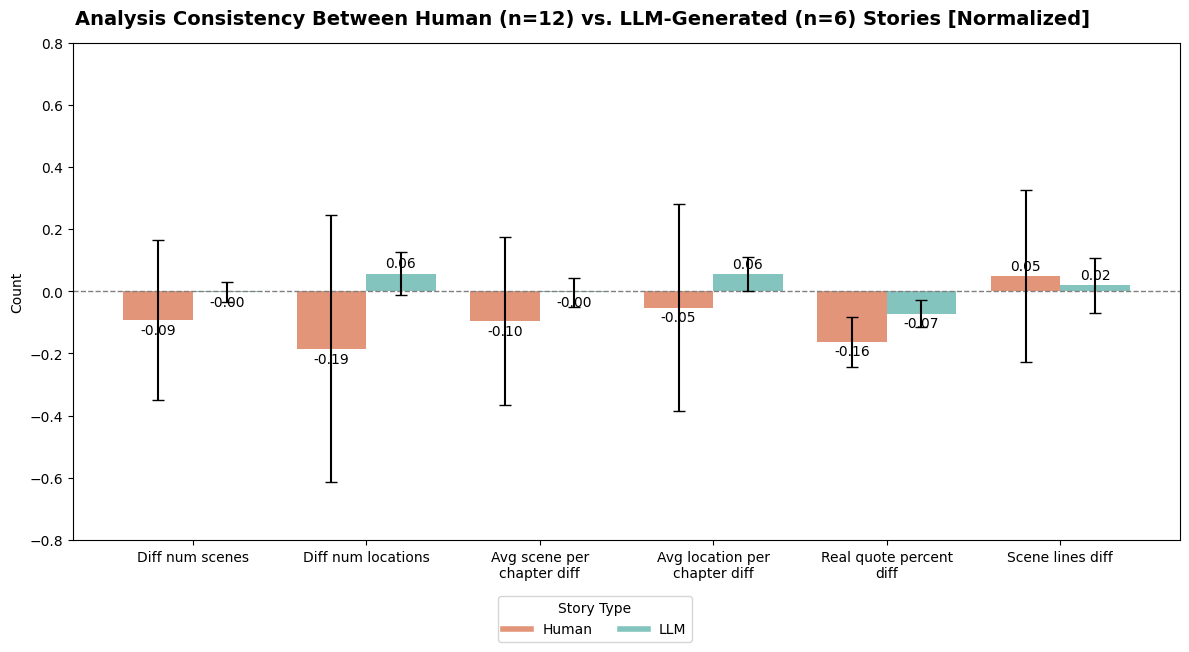

In [369]:
colors = ['#e29578', '#83c5be']
labels = ['Human', 'LLM']

# Transpose for easier plotting
avg_transposed = llm_diff_avg.transpose()
std_transposed = llm_diff_sd.transpose()
# remove 'diff_num_chapters' row
avg_transposed = avg_transposed.drop('diff_num_chapters')
std_transposed = std_transposed.drop('diff_num_chapters')

# Metrics on the x-axis
metrics = avg_transposed.index.str.replace('_', ' ').str.capitalize()

# Function to wrap labels after `n` words
def wrap_label(label, n=3):
    words = label.split()
    wrapped = '\n'.join([' '.join(words[i:i + n]) for i in range(0, len(words), n)])
    return wrapped

# Apply wrapping
wrapped_labels = [wrap_label(label, n=3) for label in metrics]

x_positions = np.arange(len(metrics))  # X positions for metrics
bar_width = 0.4

# Prepare a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Add a horizontal line at y=0
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# Calculate data range to expand y-axis
all_values = avg_transposed.values.flatten()
y_min, y_max = np.min(all_values), np.max(all_values)
y_range = y_max - y_min
# ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
ax.set_ylim(-0.8, 0.8)

# Plot bars for Character and Theme
for i, label in enumerate(labels):
    values = avg_transposed.iloc[:, i]
    std_values = std_transposed.iloc[:, i]
    
    bars = ax.bar(
        x_positions + i * bar_width - bar_width / 2,
        values,
        width=bar_width,
        color=colors[i],
        label=label,
        capsize=4,
        yerr=std_values.values,
    )

    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 0.01 if bar.get_height() < 0 else bar.get_height() + 0.01,
            f'{bar.get_height():.2f}',
            ha='center',
            va='top' if bar.get_height() < 0 else 'bottom',
            fontsize=10
        )

# Customize the x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(wrapped_labels, rotation=0, ha='center')  # Apply wrapped labels
ax.set_ylabel("Count")
ax.set_title("Analysis Consistency Between Human (n=12) vs. LLM-Generated (n=6) Stories [Normalized]", fontsize=14, fontweight='bold', x=0.46, y=1.02)

# Add a legend
fig.legend(labels=labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.09), title="Story Type",
           handles=[
               plt.Line2D([0], [0], color=colors[0], lw=4),
               plt.Line2D([0], [0], color=colors[1], lw=4),
           ])

fig.tight_layout()
plt.show()

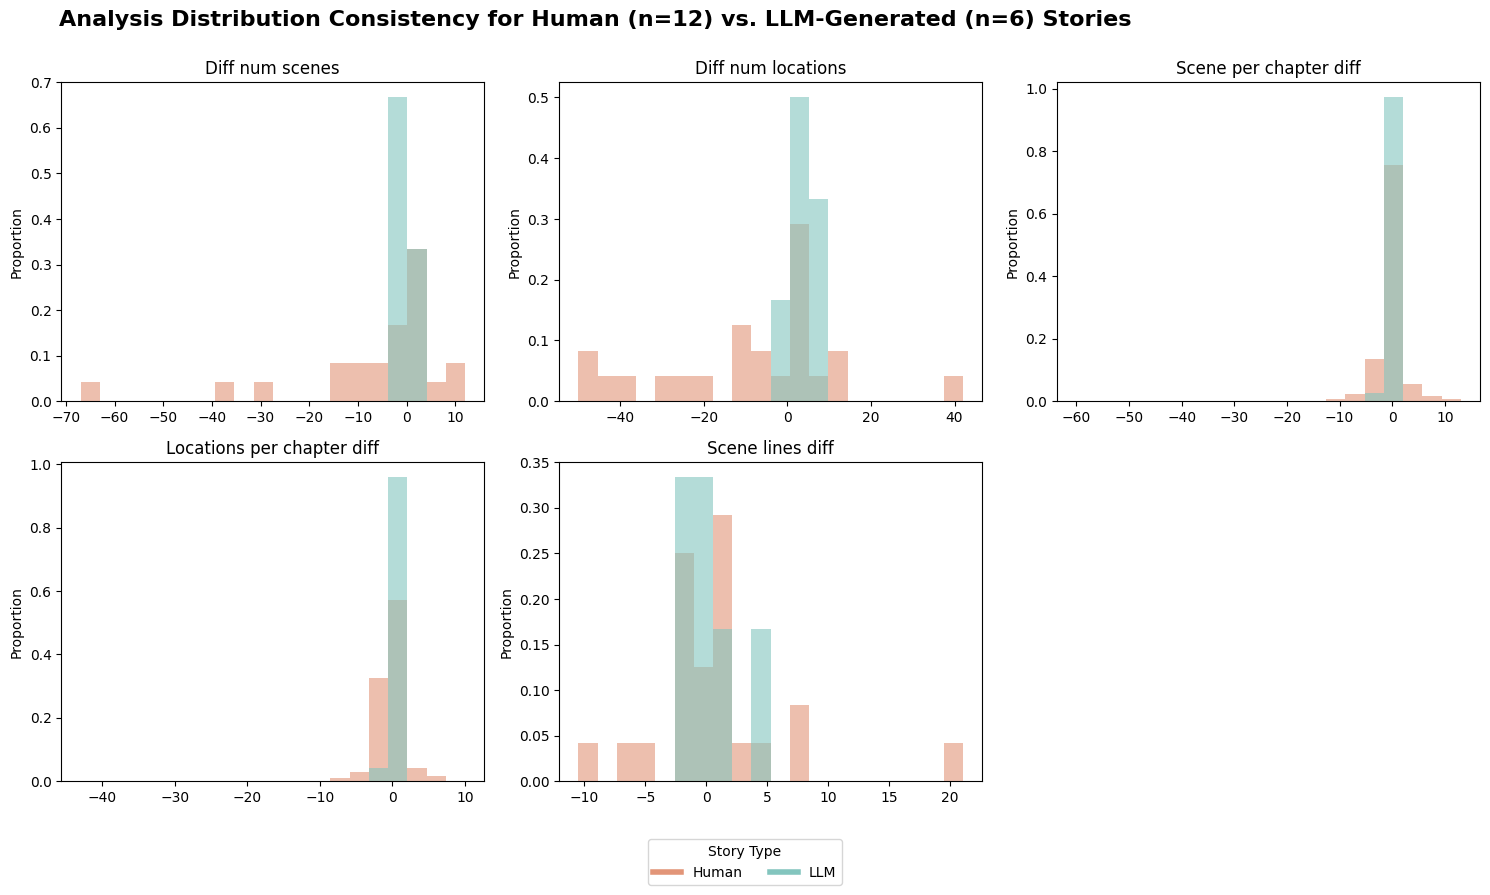

In [370]:
# Define metrics and prepare data
metrics = ['diff_num_scenes', 'diff_num_locations', 'scene_per_chapter_diff', 'locations_per_chapter_diff', 'scene_lines_diff']
num_metrics = len(metrics)
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 9), sharex=False, sharey=False)
axes = axes.flatten()

# Colors for the histograms
human_color = '#e29578'
llm_color = '#83c5be'

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for human and LLM-generated separately
    human_data = df_map[metric][df_map[metric]['llm_generated'] == False]
    llm_data = df_map[metric][df_map[metric]['llm_generated'] == True]

    # Normalize Human data
    human_counts, human_bins = np.histogram(human_data[metric], bins=20)
    human_proportions = human_counts / human_counts.sum()  # Normalize to proportions

    # Normalize LLM data
    llm_counts, llm_bins = np.histogram(llm_data[metric], bins=human_bins)  # Use same bins for comparison
    llm_proportions = llm_counts / llm_counts.sum()  # Normalize to proportions

    # Plot histograms for Human data
    ax.bar(human_bins[:-1], human_proportions, width=np.diff(human_bins), color=human_color, alpha=0.6, label="Human", align='edge')

    # Plot histograms for LLM data
    ax.bar(llm_bins[:-1], llm_proportions, width=np.diff(llm_bins), color=llm_color, alpha=0.6, label="LLM", align='edge')

    # Set titles and labels
    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")

# Hide any unused subplots
for j in range(num_metrics, len(axes)):
    axes[j].set_visible(False)

# Add main title
fig.suptitle("Analysis Distribution Consistency for Human (n=12) vs. LLM-Generated (n=6) Stories", fontsize=16, fontweight='bold', y=0.95, x=0.4)

# Add a single legend
fig.legend(labels=['Human', 'LLM'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.03), title="Story Type",
           handles=[
               plt.Line2D([0], [0], color=human_color, lw=4),
               plt.Line2D([0], [0], color=llm_color, lw=4),
           ])
fig.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()

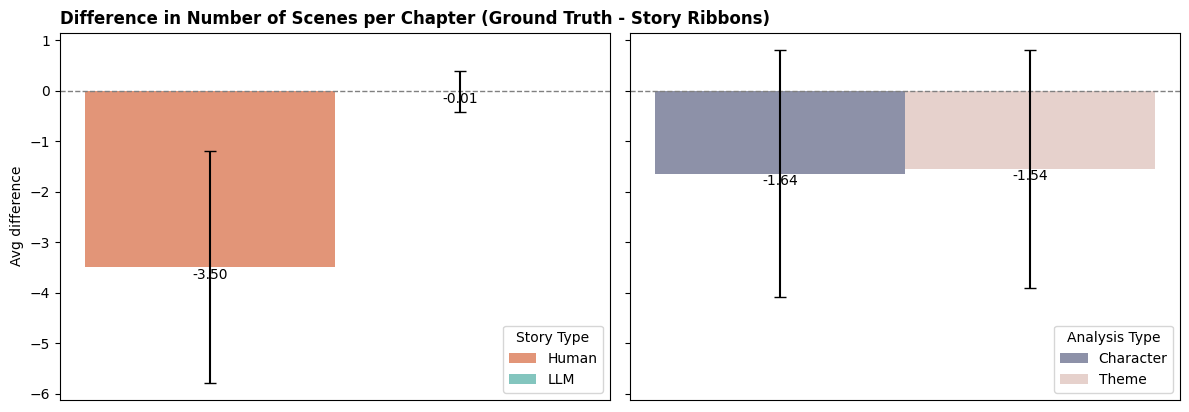

In [371]:
colors = ['#e29578', '#83c5be']
labels = ['Human', 'LLM']

# Transpose for easier plotting
avg_transposed = og_diff_avg_llm.transpose()
std_transposed = og_diff_sd_llm.transpose()
# drop 'themes' column
avg_transposed = avg_transposed.drop('themes')
std_transposed = std_transposed.drop('themes')

avg2_transposed = og_diff_avg_themes.transpose()
std2_transposed = og_diff_sd_themes.transpose()
# drop 'llm_generated' column
avg2_transposed = avg2_transposed.drop('llm_generated')
std2_transposed = std2_transposed.drop('llm_generated')

# Metrics on the x-axis
metrics = avg_transposed.index.str.replace('_', ' ').str.capitalize()

# Function to wrap labels after `n` words
def wrap_label(label, n=3):
    words = label.split()
    wrapped = '\n'.join([' '.join(words[i:i + n]) for i in range(0, len(words), n)])
    return wrapped

# Apply wrapping
wrapped_labels = [wrap_label(label, n=3) for label in metrics]

# Additional colors and labels for the second subplot
colors2 = ['#8d91a8', '#e6d1cc']  # Different color scheme
labels2 = ['Character', 'Theme']

# Prepare a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)  # sharey=True to align the y-axes

# Plot the first subplot
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
x_positions = np.arange(len(metrics))
bar_width = 0.4

for i, label in enumerate(labels):
    values = avg_transposed.iloc[:, i]
    std_values = std_transposed.iloc[:, i]
    
    bars = ax1.bar(
        x_positions + i * bar_width - bar_width / 2,
        values,
        width=bar_width,
        color=colors[i],
        label=label,
        capsize=4,
        yerr=std_values.values,
    )

    for bar in bars:
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 0.01 if bar.get_height() < 0 else bar.get_height() + 0.01,
            f'{bar.get_height():.2f}',
            ha='center',
            va='top' if bar.get_height() < 0 else 'bottom',
            fontsize=10
        )

# ax1.set_xticks(x_positions)
# ax1.set_xticklabels(wrapped_labels, rotation=0, ha='center')
ax1.set_xticks([])
ax1.set_ylabel("Avg difference")
# ax1.set_title("Difference in Number of Scenes (LLM vs Human)", fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', title="Story Type")

# Plot the second subplot
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
x_positions2 = np.arange(len(avg2_transposed.index))  # Adjust x positions for the second dataset
wrapped_labels2 = [wrap_label(label, n=3) for label in avg2_transposed.index.str.replace('_', ' ').str.capitalize()]

for i, label in enumerate(labels2):
    values = avg2_transposed.iloc[:, i]
    std_values = std2_transposed.iloc[:, i]
    
    bars = ax2.bar(
        x_positions2 + i * bar_width - bar_width / 2,
        values,
        width=bar_width,
        color=colors2[i],
        label=label,
        capsize=4,
        yerr=std_values.values,
    )

    for bar in bars:
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 0.01 if bar.get_height() < 0 else bar.get_height() + 0.01,
            f'{bar.get_height():.2f}',
            ha='center',
            va='top' if bar.get_height() < 0 else 'bottom',
            fontsize=10
        )

# ax2.set_xticks(x_positions2)
# ax2.set_xticklabels(wrapped_labels2, rotation=0, ha='center')
ax2.set_xticks([])
# ax2.set_title("Difference in Number of Scenes (Themes)", fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', title="Analysis Type")

fig.tight_layout()
# set main title
fig.suptitle("Difference in Number of Scenes per Chapter (Ground Truth - Story Ribbons)", fontsize=12, fontweight='bold', y=1.02, x=0.35)
plt.show()


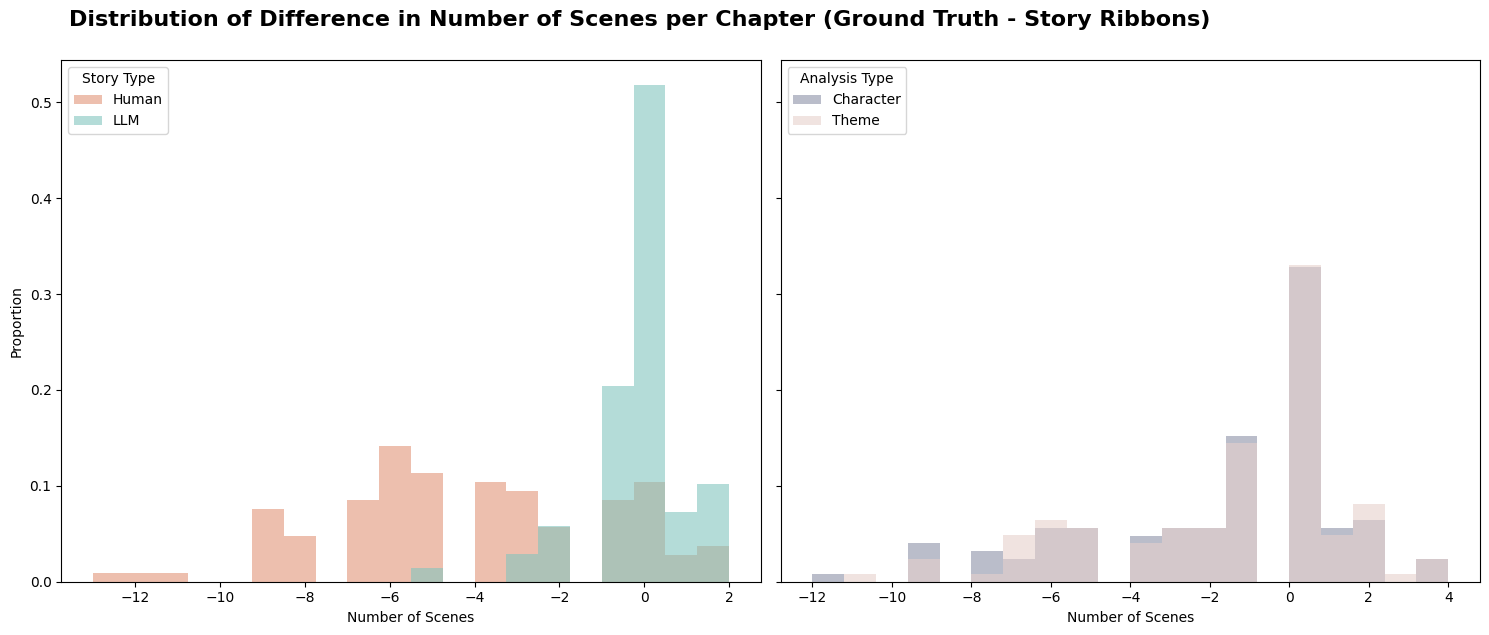

In [372]:
# Define metrics and prepare data
metrics = ['og_scene_per_chapter_diff', 'og_scene_per_chapter_diff']
og_metric_names = ['scene_per_chapter_diff', 'scene_per_chapter_diff']
num_metrics = len(metrics)
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7), sharex=False, sharey=True)
axes = axes.flatten()

# Colors for the histograms
human_color = '#e29578'
llm_color = '#83c5be'
character_color = '#8d91a8'
theme_color = '#e6d1cc'

for i, metric in enumerate(metrics):
    ax = axes[i]

    metric_name = og_metric_names[i]

    # Filter data for human and LLM-generated separately
    if i % 2 == 0:
        human_data = df_map[metric][df_map[metric]['llm_generated'] == False]
        llm_data = df_map[metric][df_map[metric]['llm_generated'] == True]
    else:
        human_data = df_map[metric][df_map[metric]['themes'] == False]
        llm_data = df_map[metric][df_map[metric]['themes'] == True]

    # Normalize Human data
    human_counts, human_bins = np.histogram(human_data[metric_name], bins=20)
    human_proportions = human_counts / human_counts.sum()  # Normalize to proportions

    # Normalize LLM data
    llm_counts, llm_bins = np.histogram(llm_data[metric_name], bins=human_bins)  # Use same bins for comparison
    llm_proportions = llm_counts / llm_counts.sum()  # Normalize to proportions

    # Plot histograms for Human data
    ax.bar(human_bins[:-1], human_proportions, width=np.diff(human_bins), color=human_color if i % 2 == 0 else character_color, 
           alpha=0.6, label="Human" if i % 2 == 0 else "Character", align='edge')

    # Plot histograms for LLM data
    ax.bar(llm_bins[:-1], llm_proportions, width=np.diff(llm_bins), color=llm_color if i % 2 == 0 else theme_color, 
           alpha=0.6, label="LLM" if i % 2 == 0 else "Theme", align='edge')

    # Set titles and labels
    # ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Proportion" if i == 0 else "")
    ax.set_xlabel("Number of Scenes")

    ax.legend(labels=['Human', 'LLM'] if i % 2 == 0 else ['Character', 'Theme'], loc='upper left', title="Story Type" if i % 2 == 0 else "Analysis Type")

# Hide any unused subplots
for j in range(num_metrics, len(axes)):
    axes[j].set_visible(False)

# Add main title
fig.suptitle("Distribution of Difference in Number of Scenes per Chapter (Ground Truth - Story Ribbons)", fontsize=16, fontweight='bold', y=0.95, x=0.43)

# Add a single legend
fig.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()

## checking quotes

In [373]:
def check_quotes(story, story_type):
    suffix = "-new-themes.json" if story_type == "themes" else "-new.json"
    with open(data_folder + story + suffix, 'r') as file:
        data = json.load(file)

    quote_count = 0
    wrong_quote_count = 0
    scenes = data["scenes"]
    for scene in scenes:
        scene_name = scene["title"]
        scene_chapter = scene["chapter"]
        scene_text = scene["text"]
        scene_text = scene_text.replace("\n", " ").replace("_", "").lower()
        scene_text = re.sub(r'[^\w\s]', '', scene_text) # remove punctuation
 
        # get all characters in scene
        characters = scene["characters"]
        for character in characters:
            # check quote
            if "No quote available" not in character["quote"]:
                og_quote = character["quote"]
                quote = og_quote.replace("_", "").lower()
                quote = re.sub(r'[^\w\s]', '', quote) # remove punctuation
                quote_count += 1
                
                # try to find in original text
                if quote not in scene_text:
                    # try searching for broken up quote
                    # quote_parts = re.split(r"[,.?!;]", quote)  # Split by comma, period, question mark, and exclamation mark
                    # quote_parts = [part.strip() for part in quote_parts]
                    # found = True
                    # min_index = 0
                    # for part in quote_parts:
                    #     find_index = scene_text.find(part, min_index)
                    #     if find_index == -1:
                    #         found = False
                    #         break
                    #     min_index = find_index + len(part)

                    # if not found:
                    wrong_quote_count += 1
                    print("Quote not found")
                    # print("part:", part)
                    print(quote)
                    print(og_quote)
                    print(scene_text)
                    print(f"Chapter: {scene_chapter}, Scene: {scene_name}, Character: {character['name']}")
                    print()

    if wrong_quote_count > 0:
        print(story, story_type)
        print(f"Wrong quotes: {wrong_quote_count}/{quote_count}")
        print("--------------------")

In [374]:
len(df["story"].unique()), df["story"].unique()

(30,
 array(['alice', 'anne', 'artofwar', 'bookstore', 'color', 'donquixote',
        'emma', 'faust', 'frankenstein', 'gatsby', 'genji', 'greatexp',
        'hamlet', 'iliad', 'marrow', 'mendips', 'metamorphosis', 'odyssey',
        'pride', 'redchamber', 'romeo', 'starlight', 'threads', 'time',
        'trial', 'ulysses', 'victoria', 'war', 'whispers', 'wizard'],
       dtype=object))

In [375]:
for i, story in enumerate(df["story"].unique()):
    # if i != 17:
    #     continue
    check_quotes(story, "characters")
    check_quotes(story, "themes")

# story = "anne"
# check_quotes(story, "characters")
# check_quotes(story, "themes")